# Chapter 2 - A/B Testing - Evaluatating a modification to your system

- Randomizing to reduce bias
- Replicating to reduce measurement variation
- Determining how many measurements to take
- Deciding to reject or accept your change

This chapter covers A/B Testing - simplest and most widely used kind of experiment
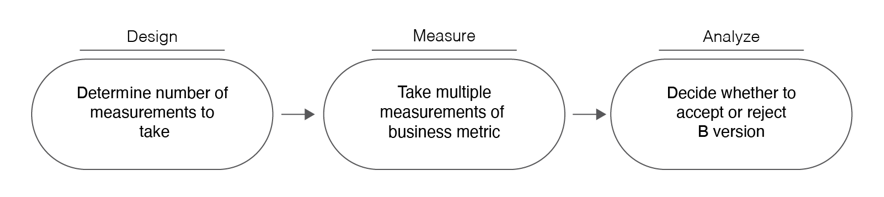

- Design: How many measurements to take? Taking multiple measurements (replication) reduces the natural variation in the results
- Measure: important to randomize as many things as possible to avoid bias
- Analyze: decide whether to switch to version B or not

## Take an ad hoc measurement

We need to understand the problem that the A/B test solves
Example: trading system

Imagine you're a quant developing a trading system. The system takes in orders and executes them. You want ot minimize the transaction costs - this is the business metric. A simple change is to buy the shares on a different exchange. At present, you trade on ASDAQ - version A. You are considering switching to BYSE - version B.

Let's simulate this!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def trading_system(system):
    """ Returns the simulated cost in mips """
    if system == 'ASDAQ':
        execution_cost = 12
    elif system == 'BYSE':
        execution_cost = 10
    execution_cost += np.random.normal()
    return execution_cost

In [2]:
# trying it out
trading_system("ASDAQ"), trading_system("BYSE")

(11.046692407118167, 9.638294054698875)

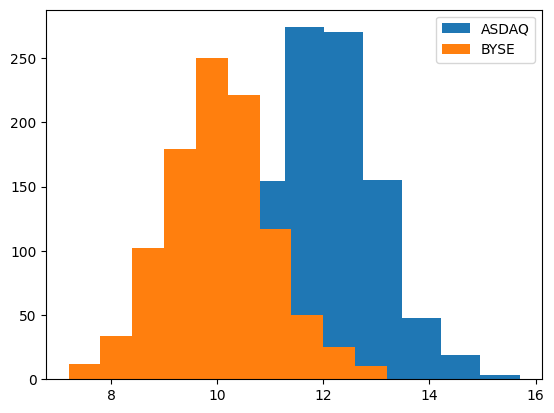

In [3]:
# Taking a bunch of different measurements:
asdaq_results = [trading_system("ASDAQ") for _ in range(1000)]
byse_results = [trading_system("BYSE") for _ in range(1000)]

fig, ax = plt.subplots()
ax.hist(asdaq_results, label="ASDAQ")
ax.hist(byse_results, label="BYSE")
ax.legend()

To get a feel for this, let's take the average over 100 different measurements for each exchange:

In [4]:
np.random.seed(17)

print(
    np.array([trading_system("ASDAQ") for _ in range(100)]).mean(),
    np.array([trading_system("BYSE") for _ in range(100)]).mean(),
)

12.111509794247766 10.008382946497413


In [5]:
# a second time
print(
    np.array([trading_system("ASDAQ") for _ in range(100)]).mean(),
    np.array([trading_system("BYSE") for _ in range(100)]).mean(),
)

11.880880186907996 9.99591773728191


Again, BYSE seems to have the lower execution cost.

**Bias**

Since you'll need to take lots of measurements, you decide to do the BYSE measurements in the morning, then take lunch, then take the ASDAQ ones. Unfortunately, you don't know that all trades are cheaper in the afternoon (due to market dynamics). Let's add this to our simulation:

In [6]:
def trading_system_tod(exchange, time_of_day):
    if time_of_day == 'morning':
        bias = 2.5
    else:
        bias = 0
    return bias + trading_system(exchange)

We've just introduced *sampling bias*: indicating that taking a measurement (or sampling) under different conditions will yield different results.

In [7]:
np.random.seed(17)
print(
    np.array([trading_system_tod("ASDAQ", "morning") for _ in range(100)]).mean(),
    np.array([trading_system_tod("ASDAQ", "afternoon") for _ in range(100)]).mean(),
)

14.611509794247766 12.008382946497411


Thus, if we go ahead with our plan, we might get results like the following:

In [8]:
np.random.seed(17)
print(
    np.array([trading_system_tod("BYSE", "morning") for _ in range(100)]).mean(), '\n',
    np.array([trading_system_tod("ASDAQ", "afternoon") for _ in range(100)]).mean(), '\n',
)

12.611509794247766 
 12.008382946497411 



If we didn't know, then we would get the wrong conclusion!

When a bias is applied differently (and consistently) to two different versions of a system, that is called *confounder bias*.

A simple trick to remove confounder bias is *randomization*. In this case, we might do this by still running tests in the morning and afternoon, but every time you make a trade you flip a coin to choose whether it is ASDAQ or BYSE.

In [9]:
def randomized_measurement():
    asdaq_measurement = []
    byse_measurement = []
    for tod in ['morning', 'afternoon']:
        for _ in range(100):
            if np.random.randint(2) == 0:
                asdaq_measurement.append(trading_system_tod("ASDAQ", tod))
            else:
                byse_measurement.append(trading_system_tod("BYSE", tod))
    return np.array(asdaq_measurement).mean(), np.array(byse_measurement).mean()

In [10]:
np.random.seed(17)
randomized_measurement()

(13.39588870623852, 11.259639285763223)

This correctly shows that ASDAQ is more expensive than BYSE.

By randomizing, we removed the effect of the bias. The especially nice thing is that we don't actually need to know about the bias to remove it via randomization. As long as we randomized everything we can, the bias disappears.


## Take a precise measurement
Variation is unpredictable and out of our control, but that doesn't mean taht there's nothing you can do about it. Even though *sometimes* BYSE gives the better result, *usually* ASDAQ is.

A concept that captures this is *expectation*. The expected value of the cost of ASDAQ and BYSE are different.

### Mitigate measurement variation with replication

We know a few facts about expectation:
1. Measurement of a business metric are reliable near their expectation
1. Future system performance is measured by expectation
1. Expectaction is predictable

An average over multiple measurements is typically closer to the expectation than a single measurement.

Thus, a better system to decide which exchange to trade on:
1. Take multiple measurements
1. Take the average
1. Use whichever exchange has the lower average cost

This process of taking multiple measurements is called *replication*

In [11]:
np.random.seed(17)
measurements = np.array([trading_system("ASDAQ") for _ in range(3)])
print(measurements)

[12.27626589 10.14537192 12.62390111]


In [12]:
# notice - close to the expectation
measurements.mean()

11.681846307513723

In [13]:
# measure the *deviation* of the individual measurements
measurements - 12

array([ 0.27626589, -1.85462808,  0.62390111])

In [14]:
# and the deviation of the mean:
measurements.mean() - 12

-0.3181536924862769

We normally measure the deviation by the *standard deviation*: $\sigma = \sqrt{\sum (x - \bar{x})^2}$

We can also use the built-in numpy .std() function.

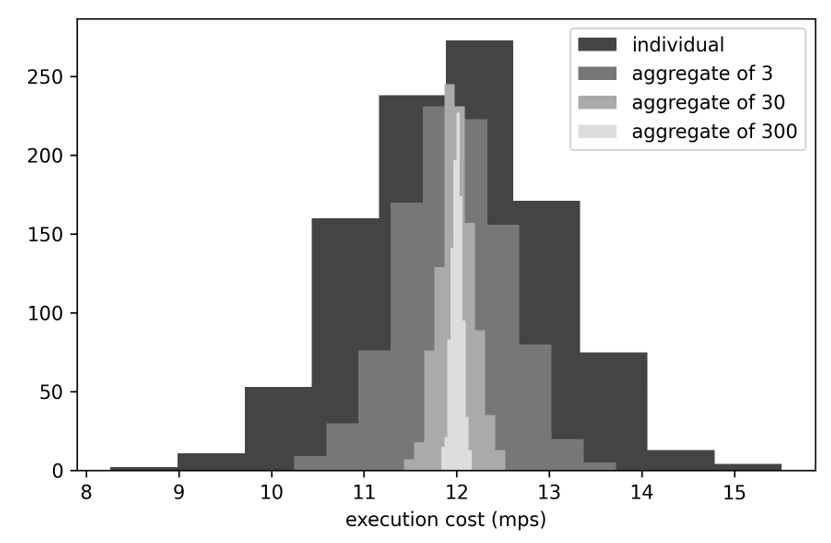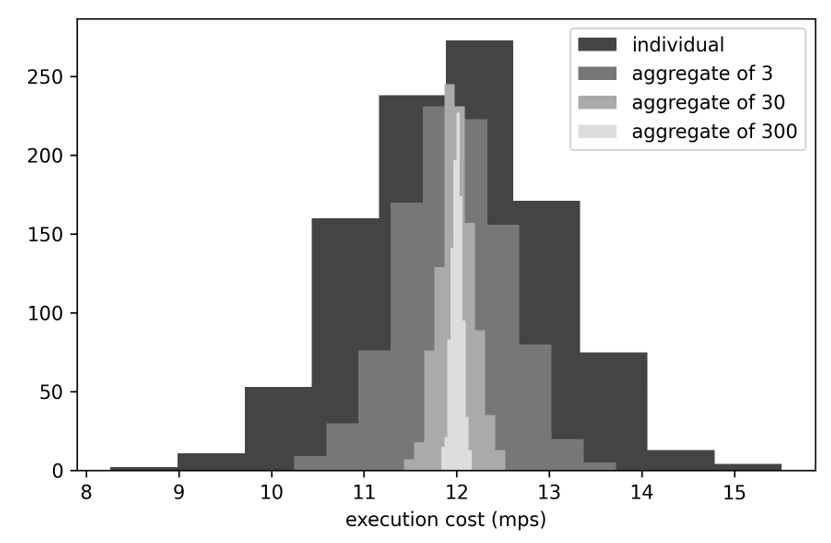

As we add more measurements to the aggregate, we get values that are closer and closer to the actual mean.

We say that an aggregate measurement is more *precise* if it is closer to the true value. By increasing the number of measurements, we improve the *precision*.

In [15]:
def aggregate_measurements(exchange, num_measurements):
    individual_measurements = np.array(
        [
            trading_system(exchange) for _ in range(num_measurements)
        ]
    )
    return individual_measurements.mean()

If we repeat this 1000 times, we get the following result:
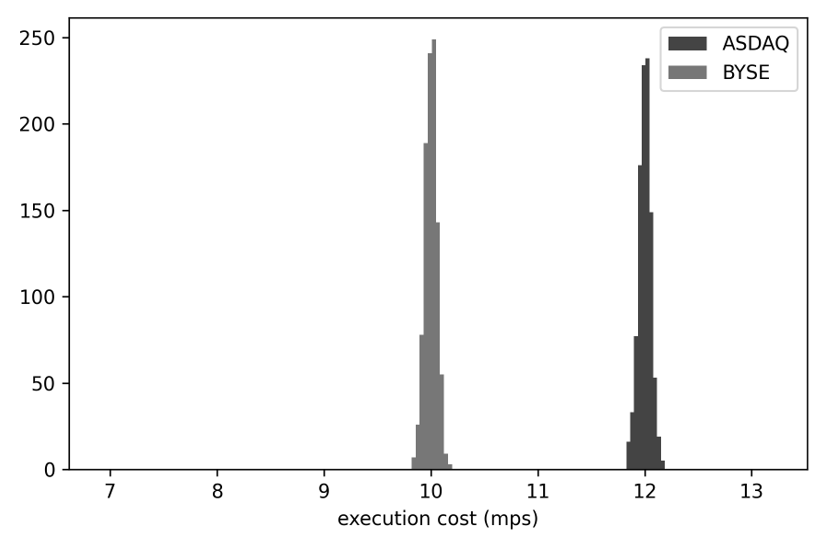!

Next, we'll take a look at the standard deviation and call it the *standard error*.

**Standard Error**

We can see how much replication reduces the standard deviation:

In [16]:
np.random.seed(17)

agg_3 = np.array([aggregate_measurements("ASDAQ", 3) for _ in range(1000)])
agg_30 = np.array([aggregate_measurements("ASDAQ", 30) for _ in range(1000)])
agg_300 = np.array([aggregate_measurements("ASDAQ", 300) for _ in range(1000)])

print(agg_3.std(), agg_30.std(), agg_300.std())

0.5721786019484487 0.18071680926647696 0.05808839858239513


We usually refer to the standard deviation of an aggregate measurement as the *standard error*. If we know the standard error (SE), then in some sense we know how far the values can stray from the expectation.

We can estimate the SE. If we take `num_measurements` measurements in an array `costs`, then:
- The aggregate measurement is `costs.mean()`
- The standard deviation of the individual measurements is `sd_1 = costs.std()`
- The standard error of the aggregate measurements is `se = sd_1 / np.sqrt(num_ind)`

We often use te following notation:
- Number of measurements: $N$
- `sd_1`: $\sigma$
- SE: $\frac{\sigma}{\sqrt{N}}$

In [17]:
# more complete aggregate measurements:
def aggregate_measurements_with_se(exchange, num_individual_measurements):
    individual_measurements = np.array([trading_system(exchange) for _ in range(num_individual_measurements)])
    aggregate_measurement = individual_measurements.mean()
    sd_1 = individual_measurements.std()
    se = sd_1 / np.sqrt(num_individual_measurements)
    return aggregate_measurement, se

In [18]:
np.random.seed(17)

print(aggregate_measurements_with_se("ASDAQ", 300))
print(aggregate_measurements_with_se("BYSE", 300))

(12.000257642551059, 0.060254756364981225)
(10.051095649188758, 0.05714189794415452)


From this, we can claim that BYSE is better - the range of its value + se is less than the value for ASDAQ - se (there is no overlap there)

So now we have a conflict - we don't want to take more measurements than we need to -they're expensive. On the other hand, if you take too few measurements there is a greter chance of the histograms overlapping. How to decide how many measurements to take?

## Run an A / B Test

Experimentation costs:
- Measurement stage will take some time. You might have to configure software, monitor for safety, get buy in...
- When measuring, half of your trades are going to the more expensive exchange. You want them all to be on the cheaper one as soon as possible!
- The less time a single experiment takes, the more experiments you can perform!

To figure out how many measurements to take, we'll start from the back

### Analyze your measurements

At this point, you have all of your measurements. When making the decision, we try to 'probably not be wrong'. 
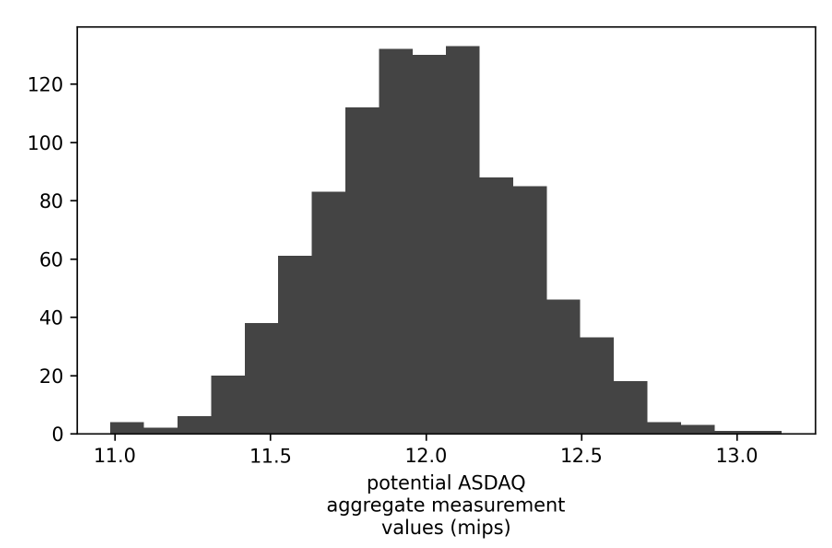

To make the analysis simpler, let's explicitly set `delta` as the difference between the aggregate measurements for ASDAQ and BYSE

In [19]:
np.random.seed(17)

num_individual_measurements = 10
agg_asdaq, se_asdaq = aggregate_measurements_with_se("ASDAQ", num_individual_measurements)
agg_byse, se_byse = aggregate_measurements_with_se("BYSE", num_individual_measurements)
delta = agg_byse - agg_asdaq
se_delta = np.sqrt(se_byse**2 + se_asdaq ** 2)

A / B testing logic works like this:
1. Assume that the difference is 0 (delta = 0)
1. If the measurement of delta is very unlikely (<5%) if delta=0, then assume that delta is not zero.

For convenience, we usually work with the $z$ score, `delta / se_delta`. This then makes the standard deviation 1.

Here;s the intuition as to how we're going to calculate the probability. $z \sim N(0, 1)$.
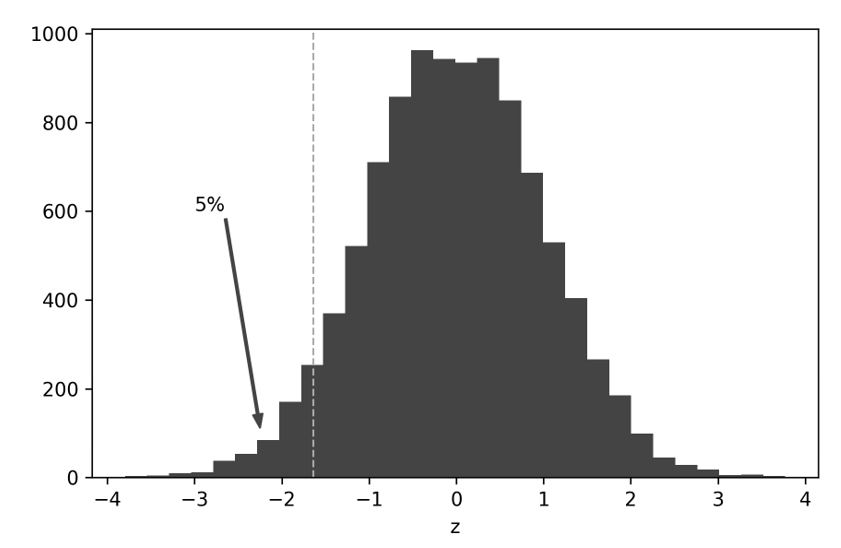

When this happens, we say that the result is *statistically significant*

When the bet is wrong ($z$ falls to the left of the line but delta isn't actually 0), we say that it's a *false positive*. By design, we will get false positives 5% of the time.

The dashed line is at -1.64 ($z \sim N(0, 1)$ by the *Central Limit Theorem*)

So, we use it like this: if $z < -1.64$, act as if BYSE is better than NYSE; otherwise, behave as though they are equal.

Another thing to keep in mind: statistical significance != practical significance. For instance, you might find that BYSE is 0.01 mip better than ASDAQ. Would it be worth switching?

### Design the A / B Test

We want to be able to tell that if the difference is great enough to be significant, we'll be able to tell.

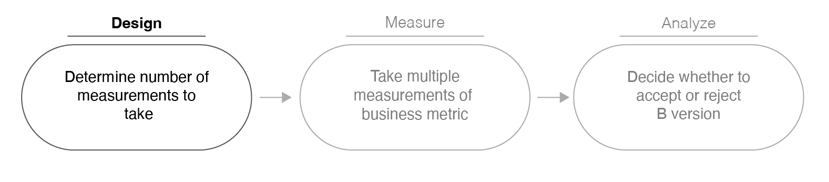

For statistical significance, we want $z < -1.64$. But `z = delta / se_delta` and `se_delta = np.sqrt(se_byse**2 + se_asdaq**2)`.

Standard error of a statistical measurement is `se = sd_1 / np.sqrt(num_ind)` where `sd_1` is the standard deviation of the individual measurements. Similarly,

`se_delta = sd_1_delta / np.sqrt(num_ind)` where `sd_1_delta = np.sqrt(sd_1_asdaq ** 2 + sd_1_byse ** 2)`. The variables `sd_1_asdaq` and `sd_1_byse` ar e the individual stds of the measurements from each exchange.

This means that we can rewrite this as

`z = np.sqrt(num_ind) * delta / sd_1_delta`

Since `z < -1.64`, 

`z = np.sqrt(num_ind) * delta / sd_1_delta < -1.64`

or rewriting, `num_ind > (1.64 * sd_1_delta / delta) ** 2`

However, there is an issue: we don't know sd_1_delta or delta until we actually take the measurements! Luckily, we can find some good substitutes

For `delta`, we can substitute the practical significance level `prac_sig`. If the actual delta is below this, we don't really care.

We can estimate `sd_1_delta` in a couple of ways:
1. Take the standard deviation of the existing measurements. You've been trading on ASDAQ, so you can grab the standard deviation from there. You can assume that the standard deviation of BYSE is the same -> `sd_1_delta = np.sqrt(2 * sd_1_asdaq ** 2)`
1. If you have reason to suspect that the differences will be large, you can run a small-scale pilot study just for the purpose of getting the std.

In [20]:
# experimental design
def ab_test_design(sd_1_delta, prac_sig):
    num_individual_measurements = (1.64 * sd_1_delta / prac_sig) ** 2
    return np.ceil(num_individual_measurements)

np.random.seed(17)
sd_1_asdaq = np.array([trading_system("ASDAQ") for _ in range(100)]).std() # estimating from the production logs
sd_1_asdaq

1.120781531568485

In [21]:
# estimating sd_1_delta
sd_1_byse = sd_1_asdaq
sd_1_delta = np.sqrt(sd_1_asdaq ** 2 + sd_1_byse ** 2)
sd_1_delta

1.5850244424014406

In [22]:
prac_sig = 1 # determined from business use

In [23]:
ab_test_design(sd_1_delta, prac_sig)

7.0

This tells us that if we take 7 measurements from each exchange, there's a 5% chance that we'll see a significant result if there's really no difference.

However, there's one more change to make: limiting the rate of *false negatives*

**False negatives**

By convention, we limit the rate of false negatives to 20%. NB You may see the false positive rate labelled as $\alpha$ and the false negative rate labelled $\beta$.

Why the difference?

If you're running an A/B test, you're already on A. False positive: you switch to B even though its worse. In that case, you are actively making the system worse. False negative: you don't switch to B even though it's better. In this case, you just keep running at the same performance level as before.

False positive: explicit cost
False negative: opportunity cost

The asymmetry reflects the fact that we have a greater aversion to doing damage (5%) against missing an opportunity (20%).

Assume that we run the test and use the rule "If z < -1.64, switch from ASDAQ to BYSE". 

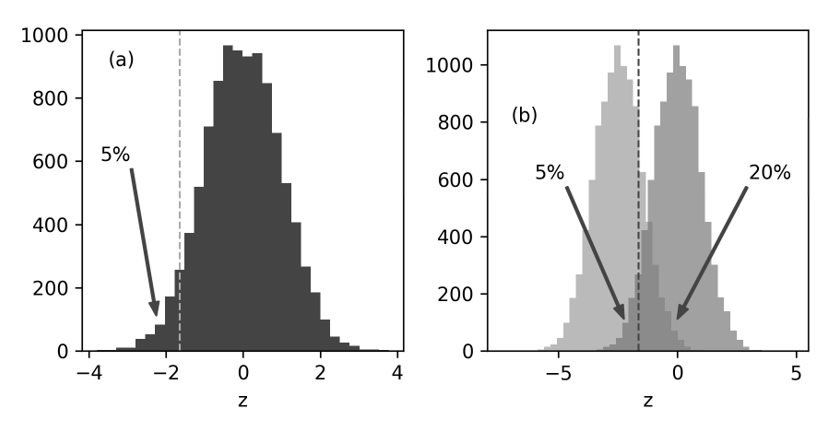

You can look up that to the right of 0.84 is 20%. Call the expectation in this case `-z0`. Then the two requirements for the line (where we decide to switch) are
1. It must be at 1.64 on the left of $z=0$, where that is the expectation where ASDAQ and BYSE are the same
1. It must be 0.84 to the right of the expectation of the distribution where BYSE is cheaper than ASDAQ. This limits the false negative rate.

For both to be true, we have $0 - 1.64 = -z0 + 0.84 \to z0 = 2.48$. Then we need to write num_ind in terms of z0. First, recall that z = delta / se_delta. Then z0 is a specific value of delta -> z0 = delta0 / se_delta. Let delta0 be the smallest difference we care about: prac_sig. That means that delta0 <= -prac_sig. Since z0 = delta0 / se_delta, z0 <= prac_sig / se_delta. Consideration of false negative rates in this way is called **power analysis**. 

Solving for num_ind:
z0 <= -prac_sig / se_delta = np.sqrt(num_ind) * (-prac_sig) / sd_1_delta

Since z0 = 2.48, 

np.sqrt(num_ind) * (-prac_sig) / sd_1_delta >= 2.48

so then num_ind >= (2.48 * sd_1_delta / prac_sig) ** 2

Compared to the earlier way, notice that we've just changed the 1.64 -> 2.48:

In [24]:
def ab_test_design_2(sd_1_delta, prac_sig):
    num_individual_measurements = (2.48 * sd_1_delta / prac_sig) ** 2
    return np.ceil(num_individual_measurements)

In [25]:
np.random.seed(17)
sd_1_asdaq = np.array([trading_system("ASDAQ") for _ in range(100)]).std()
sd_1_byse = sd_1_asdaq
sd_1_delta = np.sqrt(sd_1_asdaq ** 2 + sd_1_byse ** 2)
prac_sig = 1
ab_test_design_2(sd_1_delta, prac_sig)

16.0

So this more stringent test formulation requires 16 trades on each exchange.

### Measure and analyze

Now let's take the measurements and analyze them

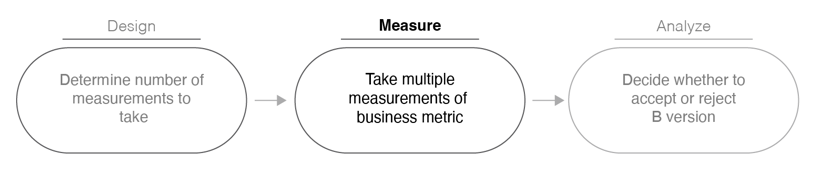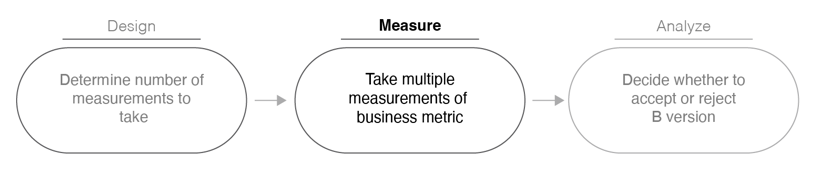

In [26]:
def measure(min_individual_measurements):
    ind_asdaq = []
    ind_byse = []
    while len(ind_asdaq) < min_individual_measurements and len(ind_byse) < min_individual_measurements:
        if np.random.randint(2) == 0:
            ind_asdaq.append(trading_system("ASDAQ"))
        else:
            ind_byse.append(trading_system("BYSE"))
    return np.array(ind_asdaq), np.array(ind_byse)

In [27]:
np.random.seed(17)
ind_asdaq, ind_byse = measure(16)
ind_byse.mean() - ind_asdaq.mean()

-2.7483767796620846

Practically significant, since it is greater than `prac_sig=1`. Is it statistically significant? We need `z < -1.64`.

In [28]:
def analyze(ind_asdaq, ind_byse):
    agg_asdaq = ind_asdaq.mean()
    se_asdaq = ind_asdaq.std() / np.sqrt(len(ind_asdaq))
    agg_byse = ind_byse.mean()
    se_byse = ind_byse.std() / np.sqrt(len(ind_byse))
    
    delta = agg_byse - agg_asdaq
    se_delta = np.sqrt(se_asdaq ** 2 + se_byse ** 2)
    z = delta / se_delta
    return z

In [29]:
analyze(ind_asdaq, ind_byse)

-6.353995237966593

This result is both practically and statistically significant. Thus, we decide to switch our system to use BYSE, alhough we recognize that there's a 5% chance that we are doing the wrong thing.